In [1]:
import os, csv, sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import PMM
MAJOR_PARTY_THRESH = 0.05

In [2]:
# ================ import data ===============
pathstr="data/raw_2011/"

year = "".join([x for x in pathstr if str.isdigit(x)])
assert str.isdigit(year), "Cannot determine year from path provided. Please include the election year in the name of your folder"
year = int(year)
assert ( int(year) < 2050 and int(year) >= 1867 ), "Inferred implausible year=%d, please check folder names for appropriate year"%year

# Define output paths:
if not os.path.exists( os.path.join( pathstr, "PMM_out") ):
    os.makedirs(os.path.join( pathstr, "PMM_out"))
f_init_standings_out = os.path.join( pathstr, "PMM_out", "party_Standings_init.tsv" )
f_qlist_out     = os.path.join( pathstr, "PMM_out", "PMM_qlist.tsv")
f_standings_out = os.path.join( pathstr, "PMM_out", "PMM_standings.tsv")

# output plots:
img_format=".pdf"
fout_figs_PMM_proj  = os.path.join( pathstr, "PMM_out", "PMM_projections"+img_format)
fout_figs_Qlist_all = os.path.join( pathstr, "PMM_out", "PMM_Qlist_all"+img_format)
fout_figs_Qlist_majparties = os.path.join( pathstr, "PMM_out", "PMM_Qlist_majparties"+img_format)


# info on total # votes cast & turnout.
T3_path = os.path.join(pathstr, "table_tableau03.csv")
# info on seats awarded
T7_path = os.path.join(pathstr, "table_tableau07.csv")
# Valid votes by party:
T8_path = os.path.join(pathstr, "table_tableau08.csv")

# character encoding changed in 2019:
if (year < 2015 ):
    df_Nvotes  = pd.read_csv( T3_path, index_col="Province", encoding = "ISO-8859-1")
    Seats_table_raw = pd.read_csv( T7_path, index_col="Province", encoding = "ISO-8859-1")
    VV_bp      = pd.read_csv( T8_path, index_col=0, encoding = "ISO-8859-1")
else:
    df_Nvotes  = pd.read_csv( T3_path, index_col="Province")
    Seats_table_raw = pd.read_csv( T7_path, index_col="Province")
    VV_bp      = pd.read_csv( T8_path, index_col=0) # index is party name:

In [3]:
Seats_init = PMM.standardize_party_labels( Seats_table_raw, PMM.party_codes_en, PMM.party_codes_fr)
# Seats_init

In [4]:
print("\n-------- BEGINING PMM PROPORTIONALITY CALCULATION -------- \n"  )

N_total_votes = df_Nvotes.iloc[:, 6].sum()
print("In Year %d, there were %d total votes cast " %(year, N_total_votes) )
print( "Of those, %.4f%% were valid." %( 100*df_Nvotes.iloc[:, 2].sum()/N_total_votes) )
print( "And %.4f%% were invalid." %( 100*df_Nvotes.iloc[:, 4].sum()/N_total_votes) )


-------- BEGINING PMM PROPORTIONALITY CALCULATION -------- 

In Year 2011, there were 14823408 total votes cast 
Of those, 99.3293% were valid.
And 0.6707% were invalid.


In [5]:
Pop_vote_share = pd.Series( VV_bp.sum(axis=1)/N_total_votes,
                            index= VV_bp.index )
# Pop_vote_share

In [6]:
# Select parties over threshold support
# Filter for parties with >5% pop support
maj_parties = Pop_vote_share.index[ Pop_vote_share > 0.05 ]

# Collect Vote_counts for maj parties, and account for spoiled and independent
Vote_counts_majparties = VV_bp.loc[maj_parties,].sum(axis=1)

In [7]:
Vote_counts = PMM.standardize_party_labels( Vote_counts_majparties, 
                                            PMM.party_codes_en, 
                                            PMM.party_codes_fr, 
                                            axis_in=0)
maj_party_standard_labels = Vote_counts.index

print( "The major parties obtaining more than 5% of the popular vote consisted of the following: ")
print("\n")
print ('\n'.join(list(maj_parties)))
print("\n")
print( "These parties obtained a combined %.2f%% of the popular vote." %(100*sum(Vote_counts)/N_total_votes))
      
# All other parties are grouped together as "OTHER"
# i.e. those who are _explicitly_ independent, as well as those whose
# parties are relegated to "independence" by falling below threshold support.
Vote_counts["OTH"] = sum( VV_bp.drop([ mp for mp in maj_parties]).sum(axis=1) )
# "SPL" captures all rejected (i.e. 'spoiled') ballots
Vote_counts["SPL"] = df_Nvotes.sum(axis=0)[4]
# Vote_counts
print( "%.2f%% of ballots were valid votes for other parties." %(100*Vote_counts["OTH"]/N_total_votes))
print( "%.2f%% of ballots were spoiled." %(100*Vote_counts["SPL"]/N_total_votes))

The major parties obtaining more than 5% of the popular vote consisted of the following: 


Bloc Québécois/Bloc Québécois
Conservative Party of Canada/Parti conservateur du Canada
Liberal Party of Canada/Parti libéral du Canada
New Democratic Party/Nouveau Parti démocratique


These parties obtained a combined 94.59% of the popular vote.
4.73% of ballots were valid votes for other parties.
0.67% of ballots were spoiled.


In [8]:
Const_Seats_all_parties_with_seats = Seats_init.drop(["TOT"],axis=1).sum()
Seats_total_init = sum( Const_Seats_all_parties_with_seats )

# Now the initial "other" (which normally just means independent) is bundled together with
# all parties below 5%, all sitting members of which are now also, effectively, "independent"
Const_Seats = Const_Seats_all_parties_with_seats[maj_party_standard_labels]
Const_Seats["OTH"] = sum( Const_Seats_all_parties_with_seats[ [p for p in Const_Seats_all_parties_with_seats.index if not p in maj_party_standard_labels ]] )
# Spoiled ballots, by definition, will always obtain zero seats.
Const_Seats["SPL"] = 0


In [9]:
Standings = pd.DataFrame( {"Votes":Vote_counts, "Seats_init": Const_Seats } )
Standings

,Votes,Seats_init
BLQ,891425.0,4
CON,5835270.0,166
LIB,2783076.0,34
NDP,4512411.0,103
OTH,701798.0,1
SPL,99428.0,0


In [10]:
parties = { Standings.index[p]: PMM.party( Standings.index[p], 
                                        Standings.iloc[p,0], 
                                        Standings.iloc[p,1],
                                        N_total_votes,
                                        Seats_total_init)
        for p in range(Standings.shape[0])}

In [11]:
party_namelist  = parties.keys()
Num_parties     = len(party_namelist)

In [12]:
Total_quotient_list=[]
for p in party_namelist:
    Total_quotient_list.extend( parties[p].party_quotient_list )
Total_quotient_list.sort(reverse=True)

In [13]:
# Sanity check, all constituency seats are assigned, and no others are:
assert all([seat.assigned for seat in Total_quotient_list[0:Seats_total_init-1]]) and not any( [seat.assigned for seat in Total_quotient_list[Seats_total_init:]] ), "ERROR: Total_quotient_list not properly sorted, or inconsistent with expected seat number."

In [14]:
# Shorten list to the first 1:2*Seats_total_init
# (nothing beyond this list has any chance of consideration.
shortlist = Total_quotient_list[:2*Seats_total_init]
Qlist = pd.DataFrame({"j"        :[ q.jval   for q in shortlist],
                      "Value"    :[ q.value  for q in shortlist],
                      "Assigned" :[ int(q.assigned) for q in shortlist],
                      "party"    :[ q.party_att     for q in shortlist],
                      } )
# --- Document the quotient list in a tsv file:
# Qlist.round(2).to_csv(f_qlist_out, sep="\t")

In [15]:
approx_Threshold = Total_quotient_list[Seats_total_init-1].value
# Initialize from the first unassigned seat
total_seats_assigned = Seats_total_init

In [16]:
sval = Seats_total_init
while (sval < 2*Seats_total_init):
    # Hard cut-off at 2*Seats_total_init no matter proportionality status.
    # Very unlikely that this will be approached.
    sval += 1
    current_party = Total_quotient_list[sval].party_att

    # scroll through and add seats until the value is below threshold.
    if (current_party == "SPL" or current_party == "OTH" ):
        continue
        # Skip OTHER, SPOILED quotients.
    elif ( (parties[current_party].vote_share*total_seats_assigned)-parties[current_party].seats_assigned) > 1 :
        # if this seat is not independent or "spoiled",
        # and is owed seats >1 then give it an extra seat:
        parties[current_party].seats_assigned += 1
        total_seats_assigned += 1
    else:
        pass

In [17]:
Standings_final = pd.DataFrame({ "Seats_initial"  :[ parties[p].Seats_initial  for p in parties],
                      "Votes"          :[ parties[p].Votes          for p in parties ],
                      "Vote_share"     :[ parties[p].vote_share     for p in parties],
                      "Seats_final"    :[ parties[p].seats_assigned for p in parties ],
                      "Seat_share"     :[(parties[p].seats_assigned)/total_seats_assigned  for p in parties]
                      }, index = parties.keys() )
Seats_total_final = Standings_final["Seats_final"].sum()

In [18]:
print(year)
print(Standings_final)

2011
     Seats_initial      Votes  Vote_share  Seats_final  Seat_share
BLQ              4   891425.0    0.060136           22    0.059459
CON            166  5835270.0    0.393652          166    0.448649
LIB             34  2783076.0    0.187749           69    0.186486
NDP            103  4512411.0    0.304411          112    0.302703
OTH              1   701798.0    0.047344            1    0.002703
SPL              0    99428.0    0.006707            0    0.000000


In [19]:
#and output to file:
# Standings_final.round(4).to_csv(f_standings_out, sep="\t")

In [20]:
# ======================================================
# Begin plotting

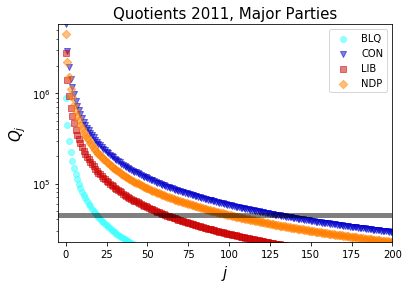

In [24]:
# Get the Q value from all parties corresponding to a full parliament (ignoring constituencies)
# i.e. if this were a pure list system, this thresh would define the cutoff for entry

# year = year 
# partylist = parties
# fout = fout_figs_Qlist_all

Full_parl_THRESH = sorted( [ q.value for q in shortlist if q.party_att in maj_party_standard_labels ] , reverse=True )[ Seats_total_init]
    
PMM.plot_quotients_each_party( maj_party_standard_labels, 
                               year=year, 
                               Full_parl_Q = Full_parl_THRESH,
                               partylist=parties, 
                               fout=fout_figs_Qlist_majparties)

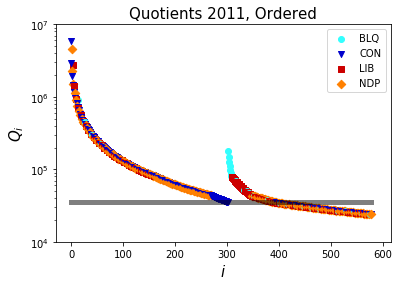

In [25]:
PMM.plot_all_quotients( maj_party_standard_labels, year, shortlist, fout_figs_Qlist_all)

0

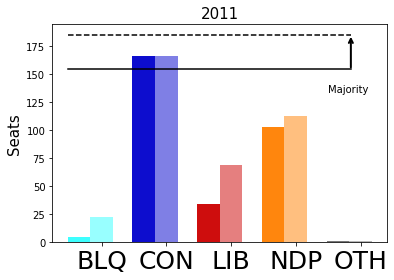

In [26]:
PMM.plot_projection( Standings_final, year, fout_figs_PMM_proj) 